In [3]:
from itertools import product

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pop_tools
import xpersist as xp

import util

In [4]:
clobber = False

In [5]:
ds_djf_epoch = xr.open_zarr('data/cesm-le-fields-djf-epoch-bias.zarr')
ds_djf_epoch

<xarray.Dataset>
Dimensions:        (epoch: 2, length: 3, member_id: 34, nlat: 93, nlon: 320, z_t: 60, z_t_150m: 15)
Coordinates:
    KMT            (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TAREA          (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLAT           (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLONG          (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULAT           (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULONG          (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    dz             (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
  * epoch          (epoch) <U9 '1991-2019' '1980-2010'
  * length         (length) float64 20.0 40.0 60.0
  * member_id      (member_id) int64 1 2 9 10 11 12 ... 35 101 102 103 104 105
  * z_t            (z_t) float32 500.0 1500.0 2500.0 ... 512502.8 537500.0
  * z_t_150m       (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
Dimensions without coordinates: nlat, nlon
Data variables:
    Chl_surf       (epoch, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 9, 47, 160), meta=np.ndarray>
    IFRAC          (epoch, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 9, 47, 160), meta=np.ndarray>
    Jint_100m_DIC  (epoch, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 9, 47, 160), meta=np.ndarray>
    KGP            (epoch, length, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 1, 17, 47, 160), meta=np.ndarray>
    NPP            (epoch, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 9, 47, 160), meta=np.ndarray>
    SST            (epoch, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 9, 47, 160), meta=np.ndarray>

In [6]:
#Epoch Diff
with xr.set_options(keep_attrs=True):  
    ds_djf_epoch_diff = ds_djf_epoch.diff('epoch').squeeze('epoch')
#ds_djf_epoch_diff

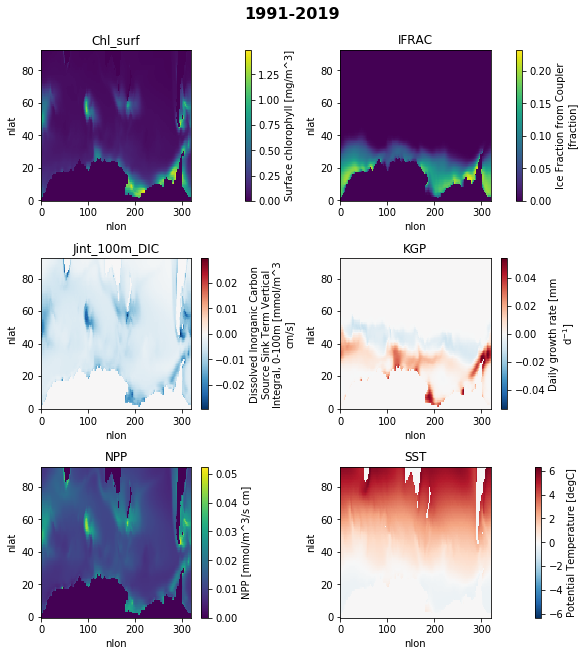

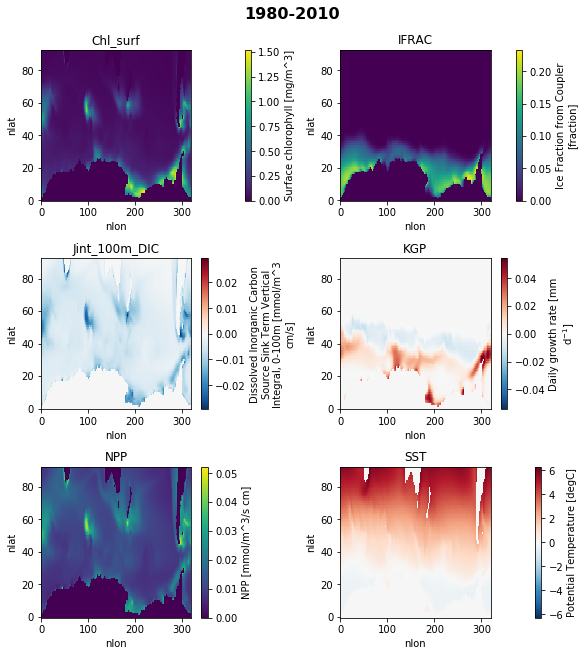

In [7]:
#check that data is actuall there:
for epoch in ds_djf_epoch.epoch.values:

    nvar = len(ds_djf_epoch.data_vars)
    ncol = int(np.sqrt(nvar))
    nrow = int(nvar/ncol) + min(1, nvar%ncol)

    fig, ax = plt.subplots(nrow, ncol, figsize=(4*ncol, 3*nrow),
                           constrained_layout=True)

    for i, v in enumerate(ds_djf_epoch.data_vars):
        plt.axes(ax.ravel()[i])

        with xr.set_options(keep_attrs=True):             
            var = ds_djf_epoch[v].sel(epoch=epoch).mean('member_id')
        if 'length' in var.dims:
            var = var.sel(length=40.)            
        var.plot()
        plt.title(v);
    plt.suptitle(epoch, fontsize=16, fontweight='bold');

In [8]:
# Get meaningful data ;)
kgp_mean = ds_djf_epoch['KGP'].where(ds_djf_epoch.KMT > 0).mean('member_id')
sst_mean = ds_djf_epoch['SST'].where(ds_djf_epoch.KMT > 0).mean('member_id')
chl_mean = ds_djf_epoch['Chl_surf'].where(ds_djf_epoch.KMT > 0).mean('member_id')

# Visualization:

In [9]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cmocean

In [10]:
# Speciffics for plotting
kgp_early = kgp_mean.sel(epoch='1991-2019', length='40')
#kgp_late = kgp_mean.sel(epoch='2070-2100', length='40')
#kgp_diff = ds_djf_epoch_diff['KGP'].where(ds_djf_epoch_diff.KMT > 0).sel(length='40').mean('member_id')

# Lat Lon Checks
lon = ds_djf_epoch.TLONG.values
lat = ds_djf_epoch.TLAT.values

In [11]:
# Make it cyclic:
dsp = util.pop_add_cyclic(
    xr.Dataset({
        'test': kgp_early,
        'TLAT': kgp_early.TLAT.compute(),
        'TLONG': kgp_early.TLONG.compute()
    } ))

In [12]:
print('mean:', dsp.test.mean().values)
print('min:', dsp.test.min().values)
print('max:', dsp.test.max().values)

mean: 0.0021154090980047904
min: -0.012388268210872033
max: 0.05391857423328686


/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [13]:
# Plotting Standards:
class MidpointNormalize(colors.Normalize):
    """
    class to help renormalize the color scale
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

############################################################################################    
#levels
limYMin = -0.28
limYMax = 0.24
levels = np.linspace(limYMin, limYMax, 13)

norm = MidpointNormalize(midpoint=0.)

extent = ([-180, 180, -90, -50], ccrs.PlateCarree()) #[120, 260, 10, 65]

prj = ccrs.SouthPolarStereo()

############################################################################################
def one_plot(da, lines=True):
    # filled contours
    cf = ax.contourf(dsp.TLONG,
                     dsp.TLAT,
                     da,
                     levels=levels,
                     norm=norm,
                     cmap=cmocean.cm.curl_r,
                     #cmap=cmocean.cm.balance,
                     #cmap=cmocean.cm.diff,
                     #extend='both',
                     transform=ccrs.PlateCarree())

    # contour lines
    cs = ax.contour(dsp.TLONG,
                    dsp.TLAT,
                    da,
                    colors='k',
                    levels=levels,
                    linewidths=0.5,
                    transform=ccrs.PlateCarree())

    if lines:
        # add contour labels
        lb = plt.clabel(cs, fontsize=6, inline=True, fmt='%r')

    # land
    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature('physical',
                                            'land',
                                            '110m',
                                            facecolor='lightgray'))

    ax.coastlines(linewidth=0.5)

    return cf


/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0.5, 1.0, 'Growth Potential (mm day$^{-1}$)')

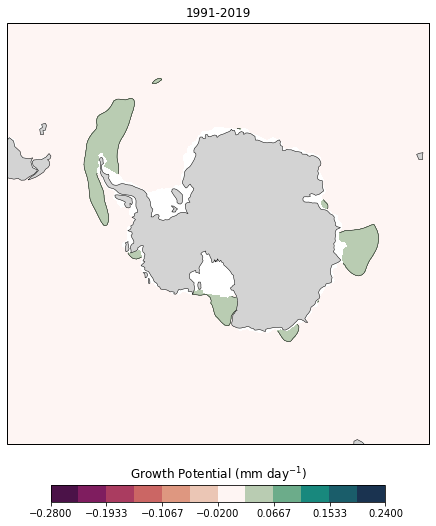

In [14]:
fig = plt.figure(figsize=(12, 10))

axs = []

# plot total
ax = fig.add_subplot(1, 1, 1, projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = one_plot(dsp.test,lines = False)
ax.set_title('1991-2019')
axs.append(ax)

# colorbar and labels
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal', pad=0.075, ax=axs)
cb.ax.set_title('Growth Potential (mm day$^{-1}$)')

## Recalculate KGP with means:

In [15]:
mean_test = ds_djf_epoch.copy()
mean_test

<xarray.Dataset>
Dimensions:        (epoch: 2, length: 3, member_id: 34, nlat: 93, nlon: 320, z_t: 60, z_t_150m: 15)
Coordinates:
    KMT            (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TAREA          (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLAT           (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLONG          (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULAT           (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULONG          (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    dz             (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
  * epoch          (epoch) <U9 '1991-2019' '1980-2010'
  * length         (length) float64 20.0 40.0 60.0
  * member_id      (member_id) int64 1 2 9 10 11 12 ... 35 101 102 103 104 105
  * z_t            (z_t) float32 500.0 1500.0 2500.0 ... 512502.8 537500.0
  * z_t_150m       (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
Dimensions without coordinates: nlat, nlon
Data variables:
    Chl_surf       (epoch, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 9, 47, 160), meta=np.ndarray>
    IFRAC          (epoch, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 9, 47, 160), meta=np.ndarray>
    Jint_100m_DIC  (epoch, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 9, 47, 160), meta=np.ndarray>
    KGP            (epoch, length, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 1, 17, 47, 160), meta=np.ndarray>
    NPP            (epoch, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 9, 47, 160), meta=np.ndarray>
    SST            (epoch, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 9, 47, 160), meta=np.ndarray>

In [16]:
# Make meaningful data ;)
mean_test['SST_m'] = ds_djf_epoch['SST'].where(ds_djf_epoch.KMT > 0).mean('member_id')
mean_test['Chl_surf_m'] = ds_djf_epoch['Chl_surf'].where(ds_djf_epoch.KMT > 0).mean('member_id')
mean_test

<xarray.Dataset>
Dimensions:        (epoch: 2, length: 3, member_id: 34, nlat: 93, nlon: 320, z_t: 60, z_t_150m: 15)
Coordinates:
    KMT            (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TAREA          (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLAT           (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLONG          (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULAT           (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULONG          (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    dz             (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
  * epoch          (epoch) <U9 '1991-2019' '1980-2010'
  * length         (length) float64 20.0 40.0 60.0
  * member_id      (member_id) int64 1 2 9 10 11 12 ... 35 101 102 103 104 105
  * z_t            (z_t) float32 500.0 1500.0 2500.0 ... 512502.8 537500.0
  * z_t_150m       (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
Dimensions without coordinates: nlat, nlon
Data variables:
    Chl_surf       (epoch, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 9, 47, 160), meta=np.ndarray>
    IFRAC          (epoch, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 9, 47, 160), meta=np.ndarray>
    Jint_100m_DIC  (epoch, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 9, 47, 160), meta=np.ndarray>
    KGP            (epoch, length, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 1, 17, 47, 160), meta=np.ndarray>
    NPP            (epoch, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 9, 47, 160), meta=np.ndarray>
    SST            (epoch, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 9, 47, 160), meta=np.ndarray>
    SST_m          (epoch, nlat, nlon) float64 dask.array<chunksize=(1, 47, 160), meta=np.ndarray>
    Chl_surf_m     (epoch, nlat, nlon) float64 dask.array<chunksize=(1, 47, 160), meta=np.ndarray>

In [17]:
def compute_kgp(ds, length):
    """Compute Krill Growth Potential

    Natural growth rates in Antarctic krill (Euphausia superba)
    doi: 10.4319/lo.2006.51.2.0973
    A Atkinson, RS Shreeve, AG Hirst, P Rothery, GA Tarling
    Limnol Oceanogr, 2006

    """

    # specify params
    a = -0.066
    b = 0.002
    c = -0.000061
    d = 0.385
    e = 0.328
    f = 0.0078
    g = -0.0101

    # local pointers
    sst = ds.SST_m
    chl = ds.Chl_surf_m

    # compute terms and sum
    length_term = a + (b * length) + (c * length**2)
    chl_term = (d * (chl / (e + chl)))
    sst_term = (f * sst) + (g * sst**2)

    kgp = length_term + chl_term + sst_term
    kgp.name = 'KGP'

    # mask based on SST range
    kgp = kgp.where((-1. <= sst) & (sst <= 5.)).fillna(0.).where(ds.KMT > 0)

    # add coordinates
    kgp = kgp.assign_coords({'length': length})
    kgp = kgp.assign_coords({'TLONG': ds.TLONG, 'TLAT': ds.TLAT})

    # add attrs
    kgp.attrs = {'units': 'mm d$^{-1}$', 'long_name': 'Daily growth rate'}
    ds['mean_KGP'] = kgp
    return ds

In [18]:
#define a length coordinate
length = xr.DataArray(
    [20., 40., 60.], 
    name='length',
    dims=('length'), 
    attrs={'units': 'mm', 'long_name': 'Krill body length'})
#length

In [19]:
recalc = compute_kgp(mean_test, length)
recalc

<xarray.Dataset>
Dimensions:        (epoch: 2, length: 3, member_id: 34, nlat: 93, nlon: 320, z_t: 60, z_t_150m: 15)
Coordinates:
    KMT            (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TAREA          (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLAT           (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLONG          (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULAT           (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULONG          (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    dz             (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
  * epoch          (epoch) <U9 '1991-2019' '1980-2010'
  * length         (length) float64 20.0 40.0 60.0
  * member_id      (member_id) int64 1 2 9 10 11 12 ... 35 101 102 103 104 105
  * z_t            (z_t) float32 500.0 1500.0 2500.0 ... 512502.8 537500.0
  * z_t_150m       (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
Dimensions without coordinates: nlat, nlon
Data variables:
    Chl_surf       (epoch, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 9, 47, 160), meta=np.ndarray>
    IFRAC          (epoch, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 9, 47, 160), meta=np.ndarray>
    Jint_100m_DIC  (epoch, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 9, 47, 160), meta=np.ndarray>
    KGP            (epoch, length, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 1, 17, 47, 160), meta=np.ndarray>
    NPP            (epoch, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 9, 47, 160), meta=np.ndarray>
    SST            (epoch, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 9, 47, 160), meta=np.ndarray>
    SST_m          (epoch, nlat, nlon) float64 dask.array<chunksize=(1, 47, 160), meta=np.ndarray>
    Chl_surf_m     (epoch, nlat, nlon) float64 dask.array<chunksize=(1, 47, 160), meta=np.ndarray>
    mean_KGP       (length, epoch, nlat, nlon) float64 dask.array<chunksize=(3, 1, 47, 160), meta=np.ndarray>

In [20]:
kgp_early2 = recalc['mean_KGP'].sel(epoch='1991-2019', length='40')
#kgp_late = recalc['mean_KGP'].sel(epoch='2070-2100', length='40')

In [21]:
# Make it cyclic:
dsp2 = util.pop_add_cyclic(
    xr.Dataset({
        'test': kgp_early2,
        'TLAT': kgp_early2.TLAT.compute(),
        'TLONG': kgp_early2.TLONG.compute()
    } ))

In [22]:
print('mean:', dsp2.test.mean().values)
print('min:', dsp2.test.min().values)
print('max:', dsp2.test.max().values);


/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater_equal
  return func(*(_execute_task(a, cache) for a in args))
/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less_equal
  return func(*(_execute_task(a, cache) for a in args))
/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater_equal
  return func(*(_execute_task(a, cache) for a in args))
/glade/work/zephyrs/

mean: -0.02965641815624287
min: -0.27949337411492814
max: 0.2292279600325617


/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater_equal
  return func(*(_execute_task(a, cache) for a in args))
/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less_equal
  return func(*(_execute_task(a, cache) for a in args))
/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater_equal
  return func(*(_execute_task(a, cache) for a in args))
/glade/work/zephyrs/

Text(0.5, 1.0, 'Growth Potential (mm day$^{-1}$)')

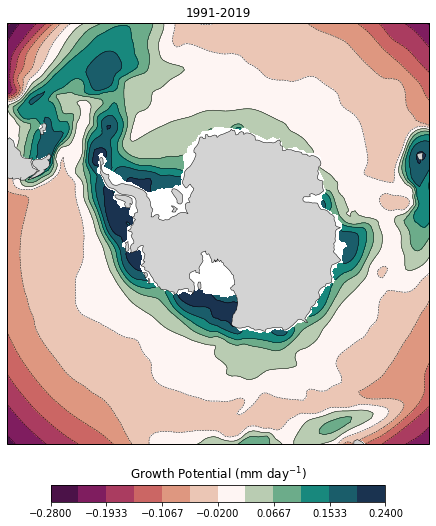

In [23]:
fig = plt.figure(figsize=(12, 10))

axs = []

# plot total
ax = fig.add_subplot(1, 1, 1, projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = one_plot(dsp2.test,lines = False)
ax.set_title('1991-2019')
axs.append(ax)

# colorbar and labels
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal', pad=0.075, ax=axs)
cb.ax.set_title('Growth Potential (mm day$^{-1}$)')

# Now try time series

In [24]:
ds_djf_regional = xr.open_zarr('data/cesm-le-fields-djf-regional-timeseries-3region.zarr')
ds_djf_regional

<xarray.Dataset>
Dimensions:        (length: 3, member_id: 34, region: 3, time: 180)
Coordinates:
  * length         (length) float64 20.0 40.0 60.0
  * member_id      (member_id) int64 1 2 9 10 11 12 ... 35 101 102 103 104 105
  * region         (region) <U17 'Southern Ocean' ... 'Atlantic Quadrant'
  * time           (time) int64 1921 1922 1923 1924 1925 ... 2097 2098 2099 2100
Data variables:
    Chl_surf       (time, member_id, region) float64 dask.array<chunksize=(180, 34, 3), meta=np.ndarray>
    IFRAC          (time, member_id, region) float64 dask.array<chunksize=(180, 34, 3), meta=np.ndarray>
    Jint_100m_DIC  (time, member_id, region) float64 dask.array<chunksize=(180, 34, 3), meta=np.ndarray>
    KGP            (time, length, member_id, region) float64 dask.array<chunksize=(90, 3, 34, 3), meta=np.ndarray>
    NPP            (time, member_id, region) float64 dask.array<chunksize=(180, 34, 3), meta=np.ndarray>
    SST            (time, member_id, region) float64 dask.array<chunksize=(180, 34, 3), meta=np.ndarray>

## Recalculate KGP with means:

In [26]:
mean_test = ds_djf_regional.copy()
mean_test

<xarray.Dataset>
Dimensions:        (length: 3, member_id: 34, region: 3, time: 180)
Coordinates:
  * length         (length) float64 20.0 40.0 60.0
  * member_id      (member_id) int64 1 2 9 10 11 12 ... 35 101 102 103 104 105
  * region         (region) <U17 'Southern Ocean' ... 'Atlantic Quadrant'
  * time           (time) int64 1921 1922 1923 1924 1925 ... 2097 2098 2099 2100
Data variables:
    Chl_surf       (time, member_id, region) float64 dask.array<chunksize=(180, 34, 3), meta=np.ndarray>
    IFRAC          (time, member_id, region) float64 dask.array<chunksize=(180, 34, 3), meta=np.ndarray>
    Jint_100m_DIC  (time, member_id, region) float64 dask.array<chunksize=(180, 34, 3), meta=np.ndarray>
    KGP            (time, length, member_id, region) float64 dask.array<chunksize=(90, 3, 34, 3), meta=np.ndarray>
    NPP            (time, member_id, region) float64 dask.array<chunksize=(180, 34, 3), meta=np.ndarray>
    SST            (time, member_id, region) float64 dask.array<chunksize=(180, 34, 3), meta=np.ndarray>

In [28]:
# Make meaningful data ;)
mean_test['SST_m'] = ds_djf_regional['SST'].mean('member_id')
mean_test['Chl_surf_m'] = ds_djf_regional['Chl_surf'].mean('member_id')
mean_test

<xarray.Dataset>
Dimensions:        (length: 3, member_id: 34, region: 3, time: 180)
Coordinates:
  * length         (length) float64 20.0 40.0 60.0
  * member_id      (member_id) int64 1 2 9 10 11 12 ... 35 101 102 103 104 105
  * region         (region) <U17 'Southern Ocean' ... 'Atlantic Quadrant'
  * time           (time) int64 1921 1922 1923 1924 1925 ... 2097 2098 2099 2100
Data variables:
    Chl_surf       (time, member_id, region) float64 dask.array<chunksize=(180, 34, 3), meta=np.ndarray>
    IFRAC          (time, member_id, region) float64 dask.array<chunksize=(180, 34, 3), meta=np.ndarray>
    Jint_100m_DIC  (time, member_id, region) float64 dask.array<chunksize=(180, 34, 3), meta=np.ndarray>
    KGP            (time, length, member_id, region) float64 dask.array<chunksize=(90, 3, 34, 3), meta=np.ndarray>
    NPP            (time, member_id, region) float64 dask.array<chunksize=(180, 34, 3), meta=np.ndarray>
    SST            (time, member_id, region) float64 dask.array<chunksize=(180, 34, 3), meta=np.ndarray>
    SST_m          (time, region) float64 dask.array<chunksize=(180, 3), meta=np.ndarray>
    Chl_surf_m     (time, region) float64 dask.array<chunksize=(180, 3), meta=np.ndarray>

In [35]:
def compute_kgp(ds, length):
    """Compute Krill Growth Potential

    Natural growth rates in Antarctic krill (Euphausia superba)
    doi: 10.4319/lo.2006.51.2.0973
    A Atkinson, RS Shreeve, AG Hirst, P Rothery, GA Tarling
    Limnol Oceanogr, 2006

    """

    # specify params
    a = -0.066
    b = 0.002
    c = -0.000061
    d = 0.385
    e = 0.328
    f = 0.0078
    g = -0.0101

    # local pointers
    sst = ds.SST_m
    chl = ds.Chl_surf_m

    # compute terms and sum
    length_term = a + (b * length) + (c * length**2)
    chl_term = (d * (chl / (e + chl)))
    sst_term = (f * sst) + (g * sst**2)

    kgp = length_term + chl_term + sst_term
    kgp.name = 'KGP'

    # mask based on SST range
    kgp = kgp.where((-1. <= sst) & (sst <= 5.)).fillna(0.)

    # add attrs
    kgp.attrs = {'units': 'mm d$^{-1}$', 'long_name': 'Daily growth rate'}
    ds['mean_KGP'] = kgp
    return ds

In [51]:
#define a length coordinate
length = xr.DataArray(
    [20., 40., 60.], 
    name='length',
    dims=('length'), 
    attrs={'units': 'mm', 'long_name': 'Krill body length'})
#length

In [52]:
recalc = compute_kgp(mean_test, length)
recalc

ValueError: arguments without labels along dimension 'length' cannot be aligned because they have different dimension size(s) {1} than the size of the aligned dimension labels: 3

### Triple Check numbers:

In [44]:
time_series_calc = recalc['mean_KGP'].sel(region='Atlantic Quadrant').mean('time')

print('mean:', time_series_calc.mean().values)
print('min:', time_series_calc.min().values)
print('max:', time_series_calc.max().values);

mean: 0.07972646966094028
min: 0.013993136327606945
max: 0.12919313632760696


# Plot

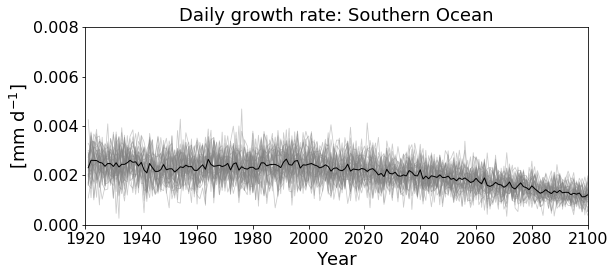

In [48]:
v = 'KGP'
limYMin = 0.0
limYMax = 0.008
region = 'Southern Ocean'

fig = plt.figure(figsize=(9, 8))
gs = gridspec.GridSpec(2,1)

ax = fig.add_subplot(gs[0, 0])
ax.set_xlim((1920, 2100))

for m_id in recalc.member_id:
    var_i = recalc[v].sel(member_id=m_id, region=region, length = 40.)
    ax.plot(recalc.time, var_i, '-', linewidth=0.8, color = 'grey', alpha = 0.4, )
    
ax.plot(recalc.time, recalc[v].sel(region=region, length = 40.).mean('member_id'),
        '-', linewidth=1, color='k')

ax.set_ylim([limYMin, limYMax])
#ax.set_ylabel(f'{ds_djf_regional[v].long_name} [{ds_djf_regional[v].units}]', fontsize = 18)
ax.set_ylabel(f'[{recalc[v].units}]', fontsize = 18)
ax.set_xlabel('Year', fontsize = 18)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_title(f'{recalc[v].long_name}: {region}', fontsize = 18)

title = (f'{region} {ds_djf_regional[v].long_name}')
path = 'figures/timeseries/'
#file = '.png'
file = '.pdf'

#plt.savefig(path + title + file, bbox_inches='tight')

In [53]:
to_plot = recalc.sel(length=40.0)
to_plot

<xarray.Dataset>
Dimensions:        (member_id: 34, region: 3, time: 180)
Coordinates:
    length         float64 40.0
  * member_id      (member_id) int64 1 2 9 10 11 12 ... 35 101 102 103 104 105
  * region         (region) <U17 'Southern Ocean' ... 'Atlantic Quadrant'
  * time           (time) int64 1921 1922 1923 1924 1925 ... 2097 2098 2099 2100
Data variables:
    Chl_surf       (time, member_id, region) float64 dask.array<chunksize=(180, 34, 3), meta=np.ndarray>
    IFRAC          (time, member_id, region) float64 dask.array<chunksize=(180, 34, 3), meta=np.ndarray>
    Jint_100m_DIC  (time, member_id, region) float64 dask.array<chunksize=(180, 34, 3), meta=np.ndarray>
    KGP            (time, member_id, region) float64 dask.array<chunksize=(90, 34, 3), meta=np.ndarray>
    NPP            (time, member_id, region) float64 dask.array<chunksize=(180, 34, 3), meta=np.ndarray>
    SST            (time, member_id, region) float64 dask.array<chunksize=(180, 34, 3), meta=np.ndarray>
    SST_m          (time, region) float64 dask.array<chunksize=(180, 3), meta=np.ndarray>
    Chl_surf_m     (time, region) float64 dask.array<chunksize=(180, 3), meta=np.ndarray>
    mean_KGP       (time, region) float64 dask.array<chunksize=(180, 3), meta=np.ndarray>

Text(0.5, 1.0, 'Daily growth rate: Southern Ocean')

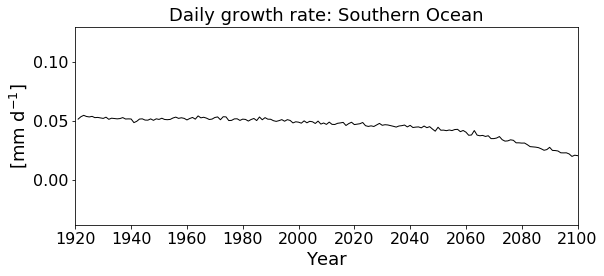

In [57]:
v = 'mean_KGP'
limYMin = -0.038
limYMax = 0.13
region = 'Southern Ocean'

fig = plt.figure(figsize=(9, 8))
gs = gridspec.GridSpec(2,1)

ax = fig.add_subplot(gs[0, 0])
ax.set_xlim((1920, 2100))

#for m_id in recalc.member_id:
#    var_i = recalc[v].sel(member_id=m_id, region=region, length = 40.)
#    ax.plot(recalc.time, var_i, '-', linewidth=0.8, color = 'grey', alpha = 0.4, )
    
ax.plot(recalc.time, recalc[v].sel(region=region, length = 40.),#.mean('member_id'),
        '-', linewidth=1, color='k')

ax.set_ylim([limYMin, limYMax])
#ax.set_ylabel(f'{ds_djf_regional[v].long_name} [{ds_djf_regional[v].units}]', fontsize = 18)
ax.set_ylabel(f'[{recalc[v].units}]', fontsize = 18)
ax.set_xlabel('Year', fontsize = 18)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_title(f'{recalc[v].long_name}: {region}', fontsize = 18)


#plt.savefig(path + title + file, bbox_inches='tight')

Text(0.5, 1.0, 'Daily growth rate: WAP & Atlantic')

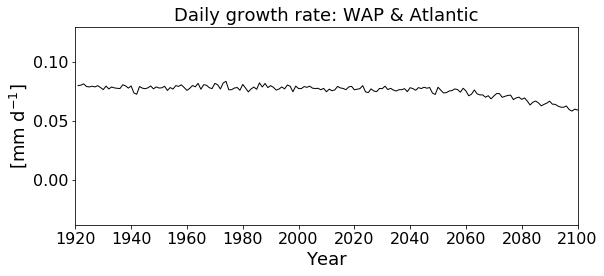

In [58]:
v = 'mean_KGP'
limYMin = -0.038
limYMax = 0.13
region = 'WAP & Atlantic'

fig = plt.figure(figsize=(9, 8))
gs = gridspec.GridSpec(2,1)

ax = fig.add_subplot(gs[0, 0])
ax.set_xlim((1920, 2100))

   
ax.plot(recalc.time, recalc[v].sel(region=region, length = 40.),#.mean('member_id'),
        '-', linewidth=1, color='k')

ax.set_ylim([limYMin, limYMax])
ax.set_ylabel(f'[{recalc[v].units}]', fontsize = 18)
ax.set_xlabel('Year', fontsize = 18)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_title(f'{recalc[v].long_name}: {region}', fontsize = 18)


#plt.savefig(path + title + file, bbox_inches='tight')

Text(0.5, 1.0, 'Daily growth rate: Atlantic Quadrant')

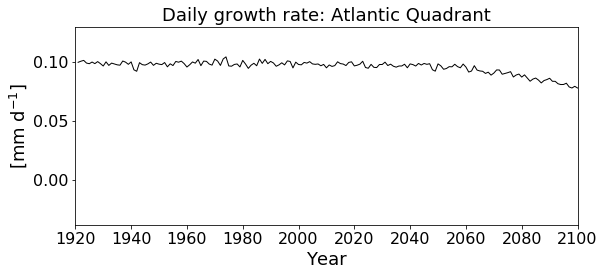

In [59]:
v = 'mean_KGP'
limYMin = -0.038
limYMax = 0.13
region = 'Atlantic Quadrant'

fig = plt.figure(figsize=(9, 8))
gs = gridspec.GridSpec(2,1)

ax = fig.add_subplot(gs[0, 0])
ax.set_xlim((1920, 2100))

   
ax.plot(recalc.time, recalc[v].sel(region=region, length = 40.),#.mean('member_id'),
        '-', linewidth=1, color='k')

ax.set_ylim([limYMin, limYMax])
ax.set_ylabel(f'[{recalc[v].units}]', fontsize = 18)
ax.set_xlabel('Year', fontsize = 18)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_title(f'{recalc[v].long_name}: {region}', fontsize = 18)


#plt.savefig(path + title + file, bbox_inches='tight')